# Smaller scale SINDy
This notebook focuses in on a somewhat smaller scale of clean data to try to get SINDy working better

In [16]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

In [17]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [18]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [19]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [20]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = start_time # datetime.datetime(2023, 8, 24, 16) # 25
endt = end_time # datetime.datetime(2023, 8, 26, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - start_dist).argmin()
endind_d = np.absolute(plot_dists - end_dist).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [21]:
contour_values = np.linspace(0.55, 2.2, 100) # 0.55
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
# np.empty((len(contour_values), len(filtered_arr[:, 1])))
nan_inds = {}
real_inds = {}
depths_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds[cvi] = []
    real_inds[cvi] = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        if(len(xc) == 1):
            real_inds[cvi].append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_int[i]).tolist())
        else:
            nan_inds[cvi].append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    # print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr[:, 0]), 'zero crossings')
    
    nan_inds[cvi] = np.array(nan_inds[cvi])
    real_inds[cvi] = np.array(real_inds[cvi])

    cvi = cvi + 1

contour_points_arr_interp = np.empty( (100, len(plot_times_zoomed)) )
depths = np.nanmedian(contour_points_arr, axis=1)
depths_interp = np.linspace(plot_dists_zoomed[0], plot_dists_zoomed[-1], len(contour_points_arr_interp[:, 0]))

for i in range(len(contour_points_arr[0, :])):
    real_inds = np.where(~np.isnan(contour_points_arr[:, i]))[0]
    contour_points_arr_interp[:, i] = np.interp(depths_interp, depths[real_inds], contour_points_arr[real_inds, i])

# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

## Plotting

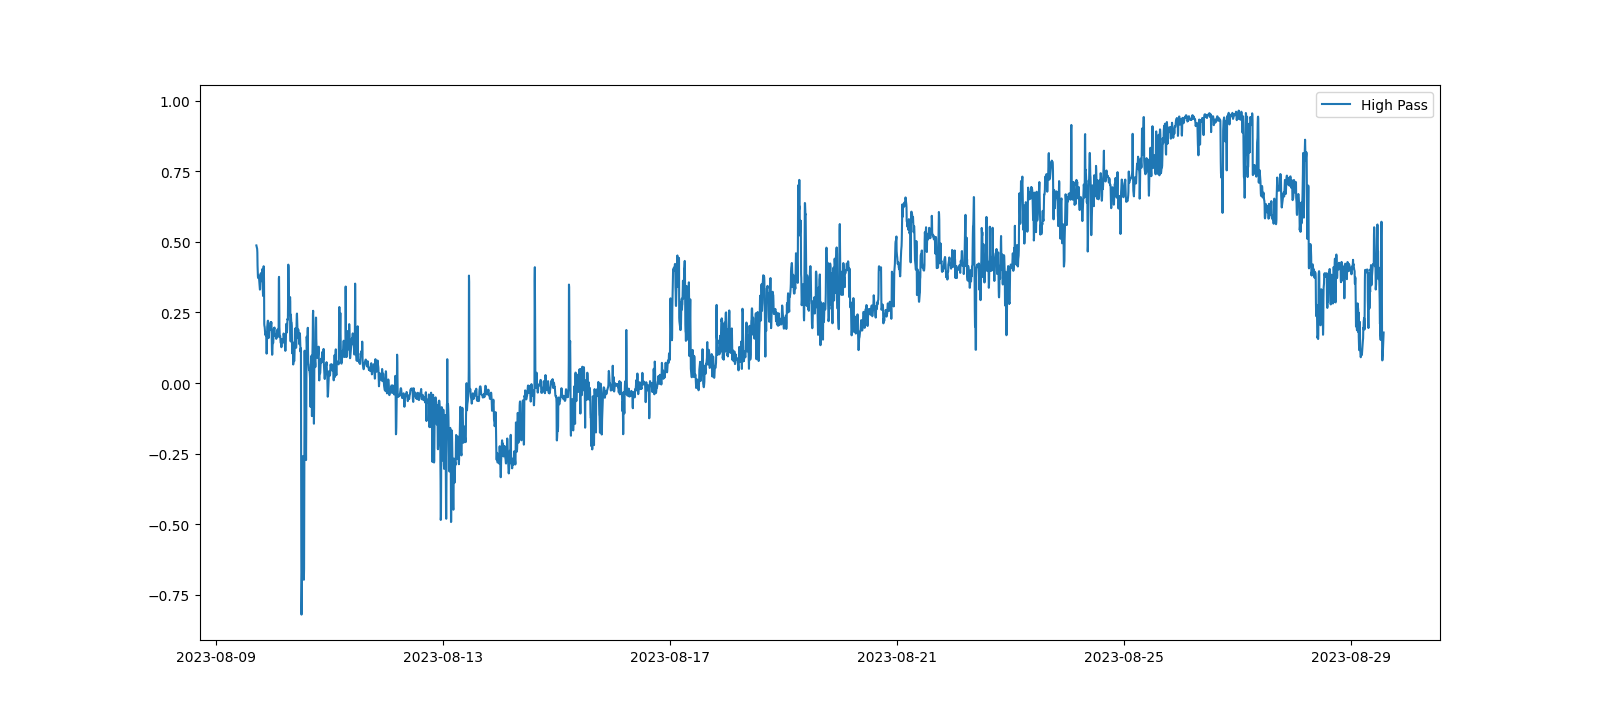

In [31]:
depths = np.empty(np.shape(contour_points_arr_interp))
displacements = np.empty(np.shape(contour_points_arr_interp))

filter = scipy.signal.butter(1, 0.5, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate

for i in range(len(contour_points_arr_interp[:, 0])):
    depths[i, :] = depths_interp[i]
    # High pass filter each channel
    # contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
    # displacements[i, :] = contour_points_arr_interp[i, :] - np.mean(contour_points_arr_interp[i, :])
    # displacements[i, :] = contours_high_pass #contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :])   #  contours_high_pass

displacements = contour_points_arr_interp - np.median(contour_points_arr_interp)
## Normalize displacements ## 
displacements = (displacements - np.min(displacements)) / (np.max(displacements) - np.min(displacements))
displacements = 2 * displacements - 1

i = 60 # np.absolute(depths - 3027).argmin()
contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(plot_times_zoomed, displacements[i, :])
plt.ylabel("Vertical displacement")
# ax.plot(contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
# ax.plot(contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
ax.legend(['High Pass', 'Original'])

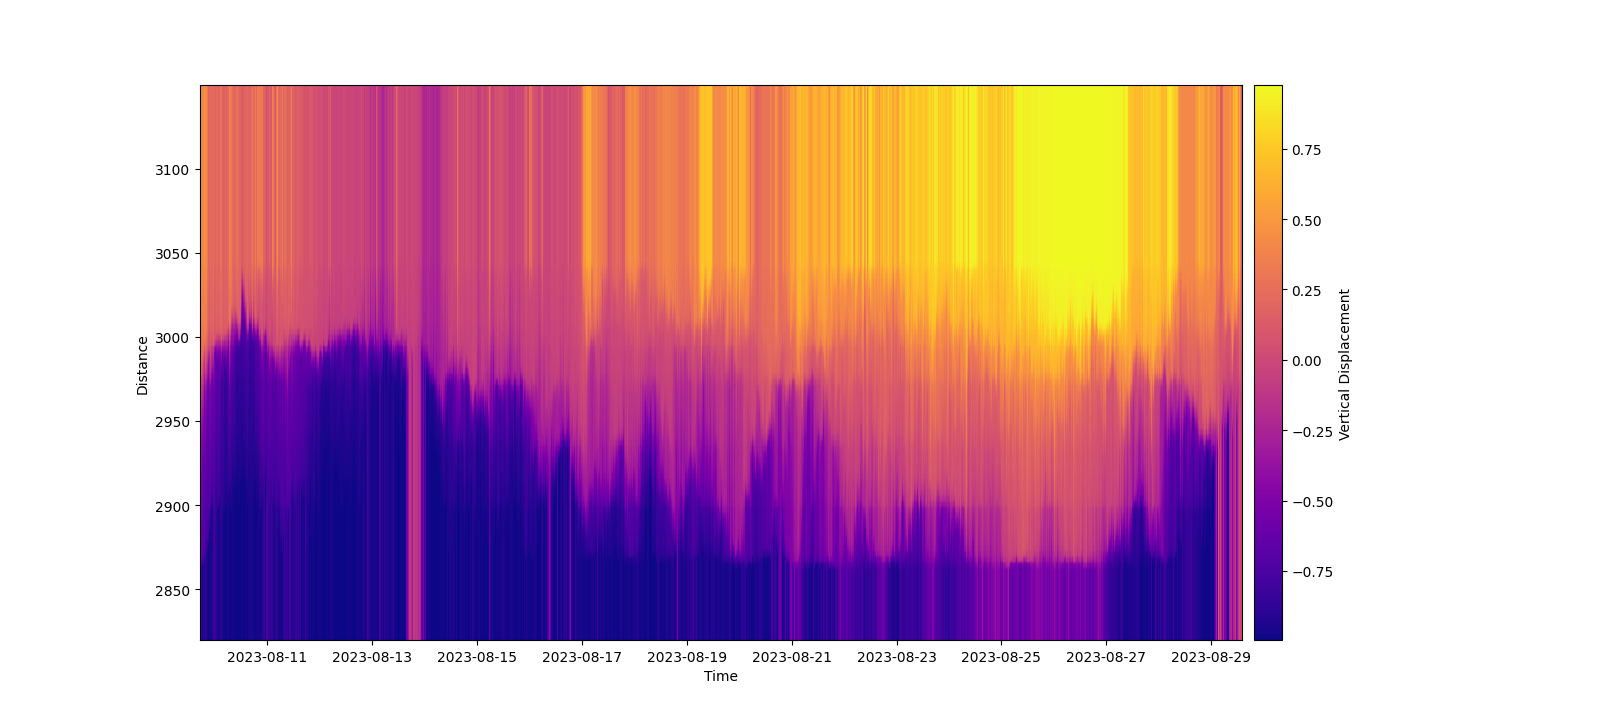

In [23]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
ddt = np.gradient(displacements, axis=1)
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


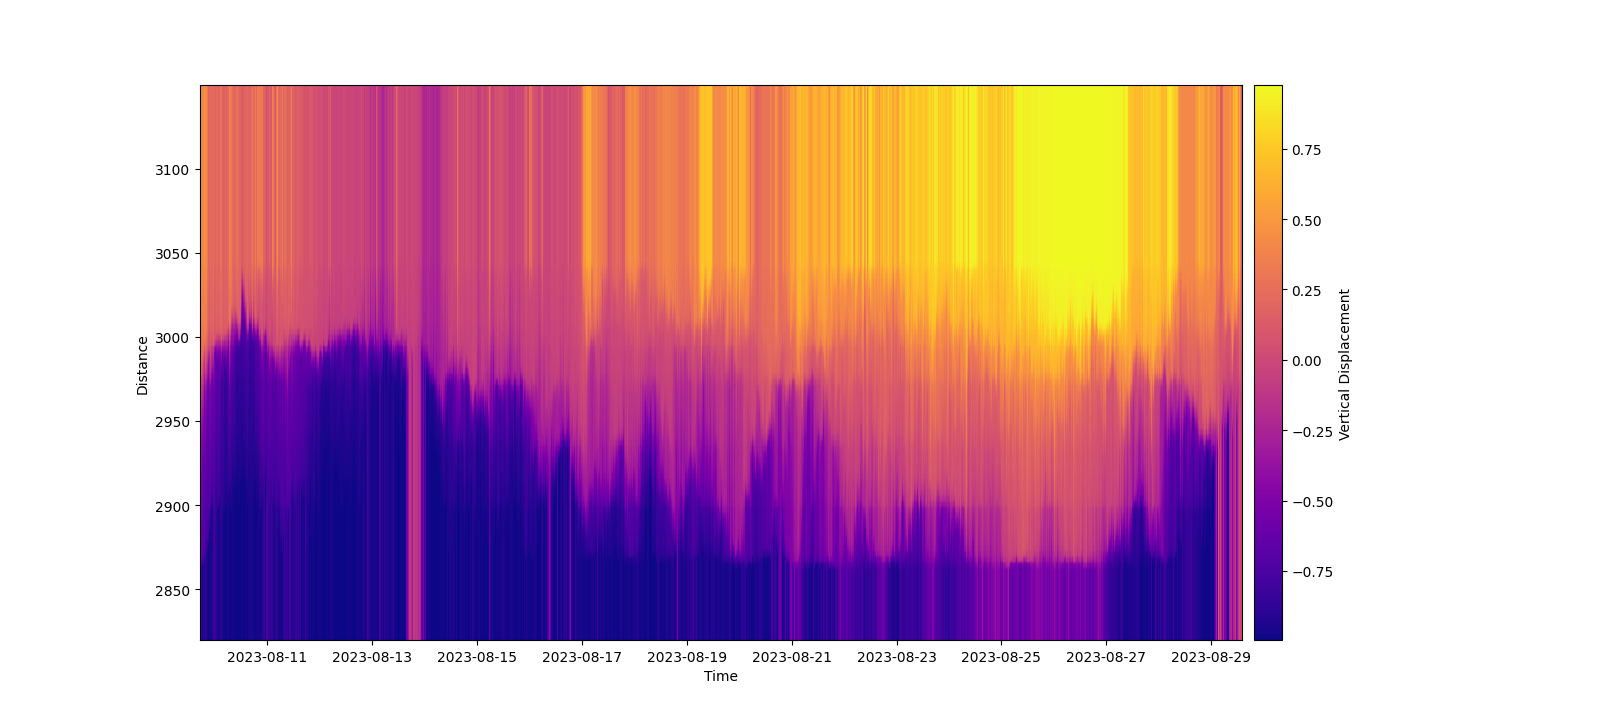

In [24]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
ddt = np.gradient(displacements, axis=1)
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


## Temperature plotted data and slice of disps

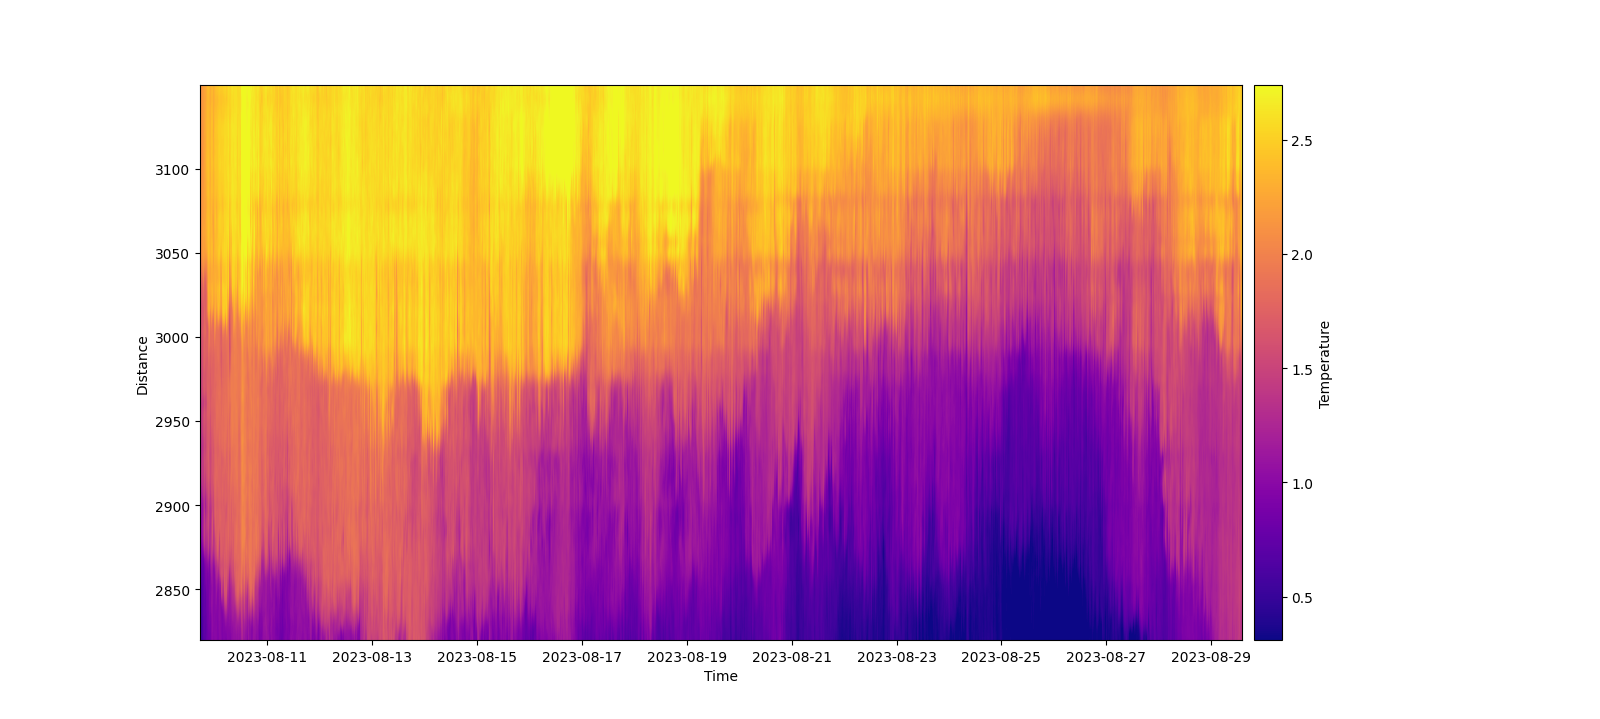

In [25]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

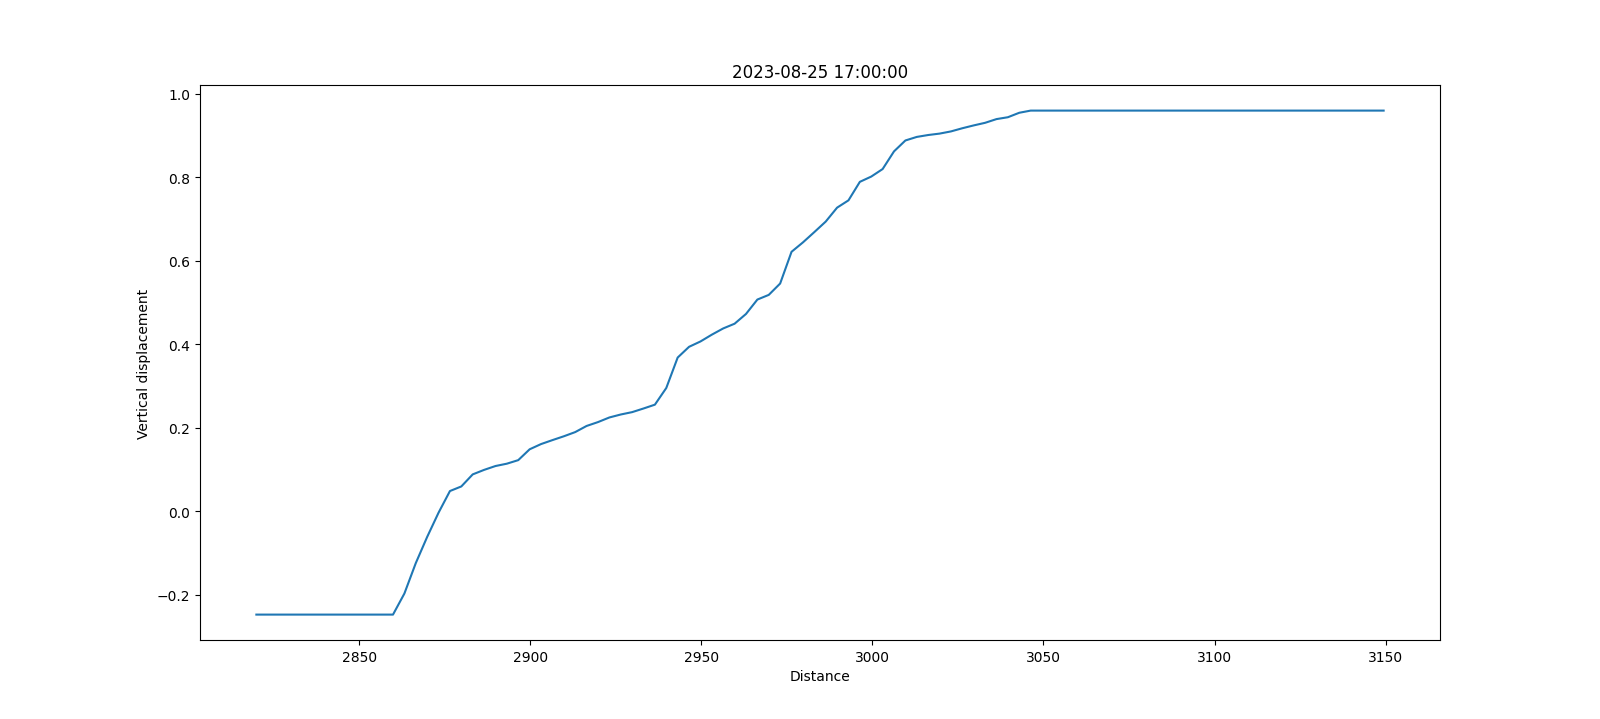

In [26]:
time_slice = datetime.datetime(2023, 8, 25, 17)
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(depths[:, np.absolute(plot_times_zoomed - time_slice).argmin()], displacements[:, np.absolute(plot_times_zoomed - time_slice).argmin()])
ax.set_xlabel('Distance')
ax.set_ylabel('Vertical displacement')
ax.set_title(str(time_slice))
plt.show()

# Set up SINDy

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Actual SINDy Stuff

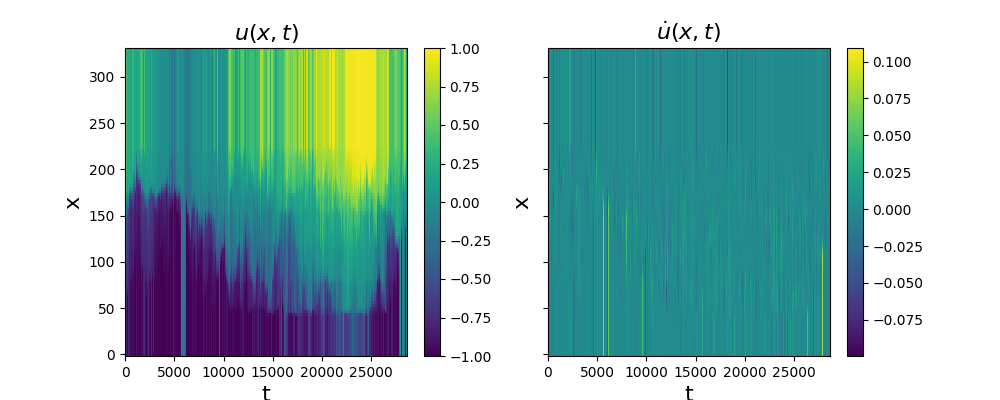

In [28]:
# Example data (replace with your actual data)
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths[:, 0] - depths[0, 0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = displacements
v_sol = ps.SmoothedFiniteDifference(axis=1)._differentiate(u_sol, t=dt)


u = np.zeros((len(x), len(t), 2))
u[:, :, 0] = u_sol
u[:, :, 1] = v_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u[:, :, 0], shading='nearest')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot[:, :, 0], shading='nearest')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.colorbar()
plt.show()


In [29]:
train = range(0, int(len(t) * 0.6))
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train, :]
u_test = u[:, test, :]
u_dot_train = u_dot[:, train, :]
u_dot_test = u_dot[:, test, :]
t_train = t[train]
t_test = t[test]

library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)
print(x.shape, u_dot_train.shape, u_dot_test.shape, t_train.shape, t_test.shape)

print('STLSQ model')
optimizer = ps.STLSQ(
    threshold=9e-4,
    max_iter=100000,
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train, ensemble=True, quiet=True)
model.print()
u_dot_sr3 = model.predict(u_test)

(100,) (100, 3427, 2) (100, 2286, 2) (3427,) (2286,)
STLSQ model
(x0)' = 1.000 x1
(x1)' = -0.001 x0x0x0 + -0.830 x0x1x1 + 0.007 x0_1 + 0.142 x1_1 + 0.014 x0_11 + -43.682 x0x0x0x0_1 + 41.679 x1x1x1x1_1 + 0.345 x0x1x1x0_1 + -7593.030 x0x1x1x1_1 + -32.613 x0x0x1x0_1 + -24.159 x0x0x1x1_1 + 0.019 x0x0_11 + 105.064 x1x1x1x1_11 + 34667.344 x0x1x1x1_11 + -233.548 x0x0x1x1_11


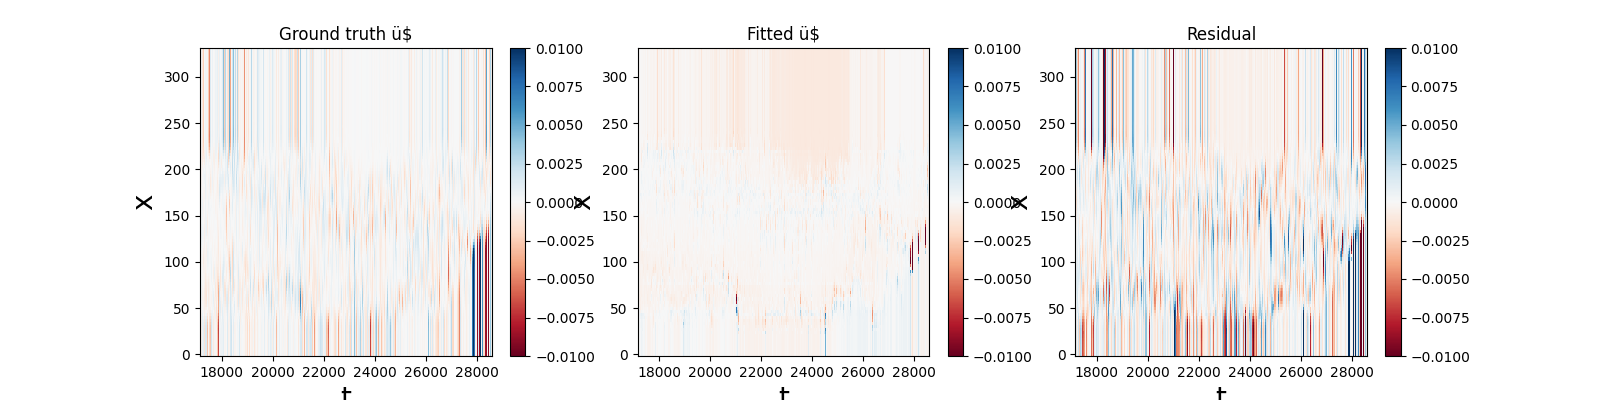

In [30]:
%matplotlib widget

# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t_test, x, u_dot_test[:, :, 1], vmin=-0.01, vmax=0.01, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth ü$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t_test, x, 2*u_dot_sr3[:,:,1], vmin=-0.01, vmax=0.01, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted ü$')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t_test, x, u_dot_sr3[:,:,1] - 2*u_dot_test[:,:,1], vmin=-0.01, vmax=0.01, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()